# A/B Testing Project: Free Trial Screener

This work was based on the final project from the A/B Testing MOOC course that I took at Udacity in September 2018.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import stats

# Part I: Experiment Overview 

In the experiment, Udacity tested a change where if the student clicked "start free trial" after viewing a course overview page, they were asked how much time they had available to devote to a course. This screenshot shows what the experiment looks like.

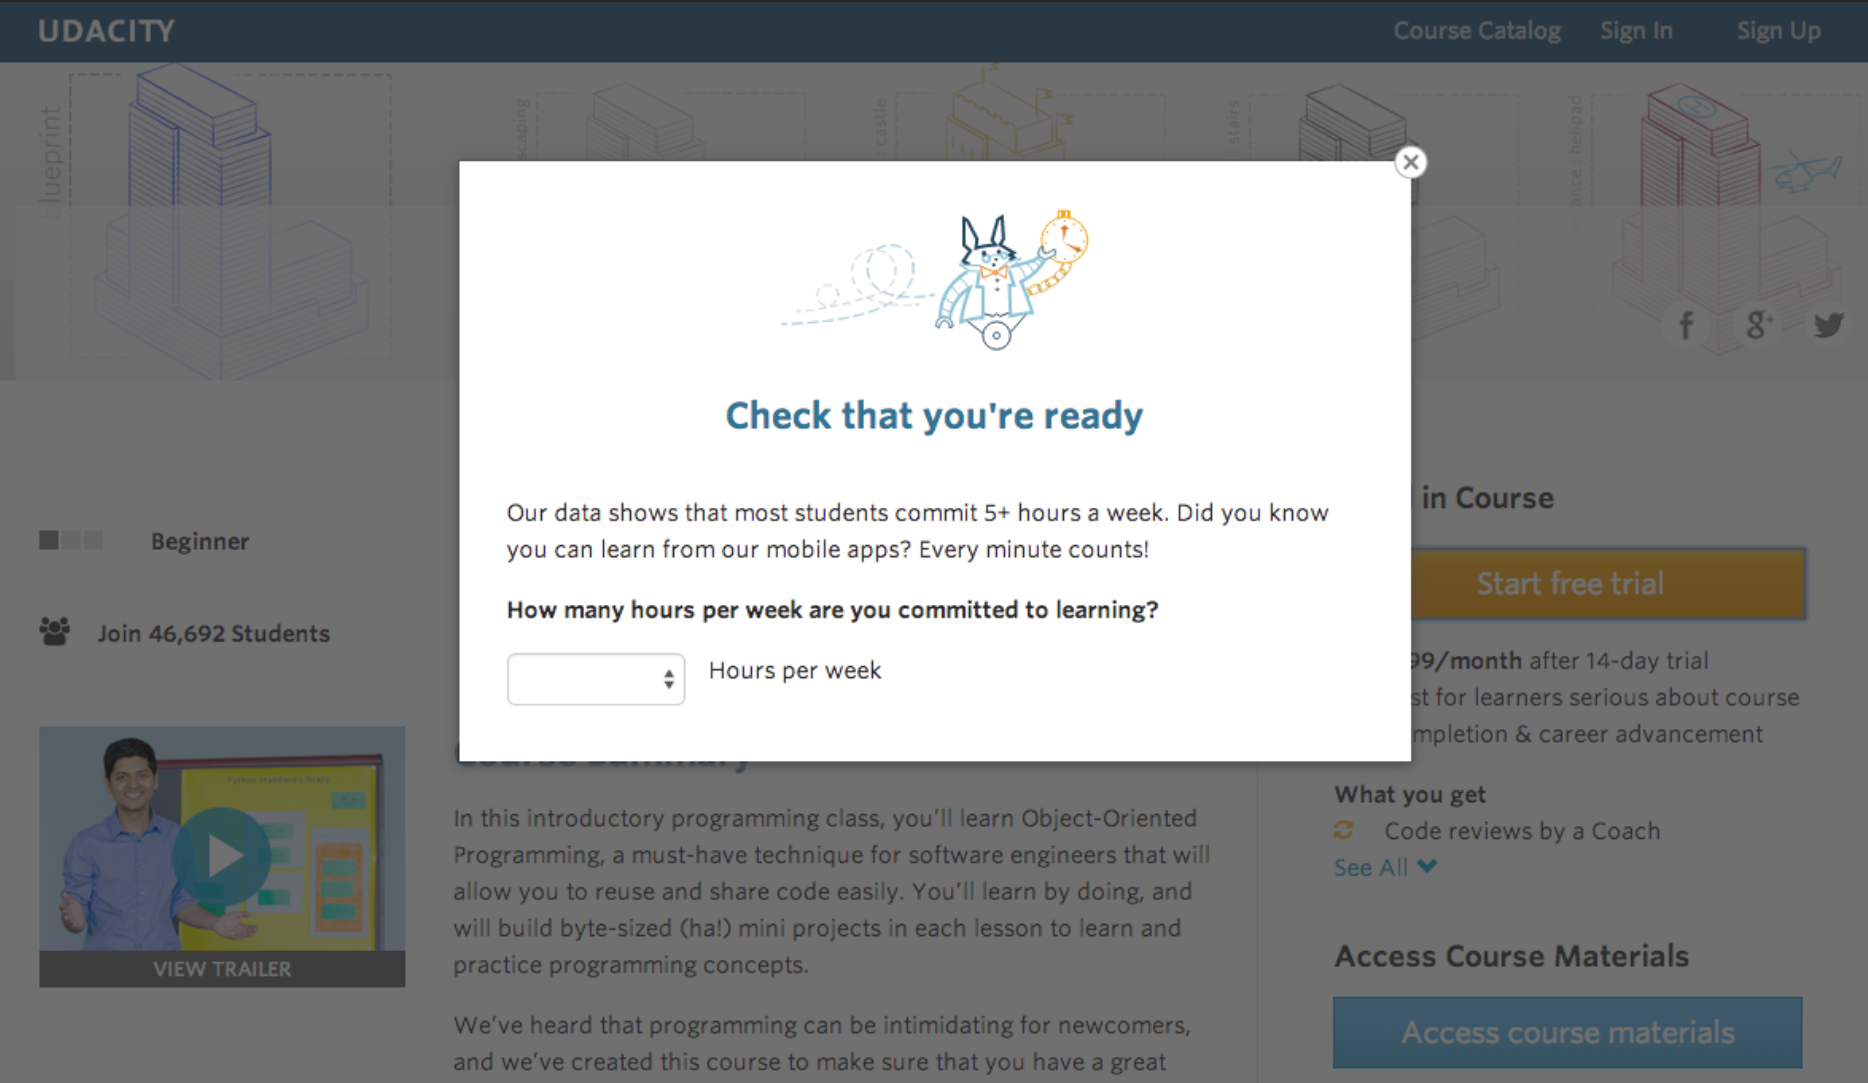

In [2]:
Image.open('free trial screener.png')

If the student indicated 5 or more hours per week, they would be taken through the checkout process as usual. 

If they indicated fewer than 5 hours per week, a message would appear suggesting that the student might like to access the course materials for free. 

The hypothesis was that this might set clearer expectations for students upfront, thus reducing the number of frustrated students who left the free trial because they didn't have enough time. 

A detailed overview can be found here: [Final Project Instructions](https://docs.google.com/document/u/1/d/1aCquhIqsUApgsxQ8-SQBAigFDcfWVVohLEXcV6jWbdI/pub?embedded=True). 

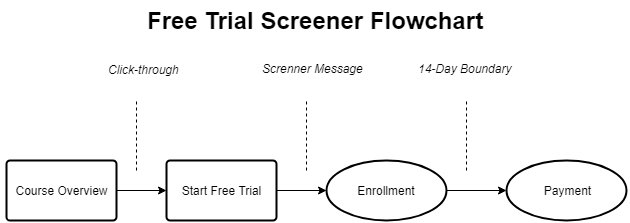

In [3]:
Image.open('flowchart1.png')

## Part II: Experiment Design

### Metric Choice

#### 1. Unit of Diversion

The unit of diversion is a **cookie**, but as soon as a student enrolls in the free trial, he or she will be tracked by user-id moving forward. 

#### 2. Unit of Analysis

In [4]:
# Import data frame for baseline values 
baseline = pd.read_csv('final_project_baseline_values.csv')

baseline

,Evaluation_metric,Baseline_value
0,Unique cookies to view course overview page pe...,40000.000000
1,"Unique cookies to click ""Start free trial"" per...",3200.000000
2,Enrollments per day:,660.000000
3,"Click-through-probability on ""Start free trial"":",0.080000
4,Gross conversion,0.206250
5,Retention,0.530000
6,Net Conversion,0.109313


The use of **baseline values**: 

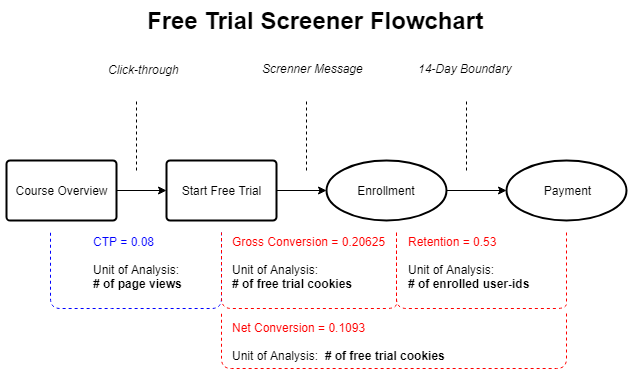

In [5]:
Image.open('flowchart.png')

#### 3. Invariant Metrics



In [6]:
# Number of Cookies
baseline_cookies = baseline.values[0,1]

# Number of Free Trial Cookies
baseline_free_trial_cookies = baseline.values[1,1]


#### 4. Evaluation Metrics

In [7]:
# Gross Conversion
baseline_gc = baseline.values[4,1]

# Retetion 
baseline_rt = baseline.values[5,1]

# Net Conversion
baseline_nc = baseline.values[6,1]

### Measuring Standard Deviation

For each evaluation metric, calculate analytic estimate of its standard deviation, given a sample size of 5000 cookies visiting the course overview page. 


In [8]:
sample_size = 5000
CTP = baseline.values[3,1]


# Number of free trial cookies
free_trial_cookies = sample_size*CTP
free_trial_cookies

400.0

In [9]:
# Number of enrolled user-ids
enrolled_user_ids = free_trial_cookies*baseline_gc
enrolled_user_ids

82.5

In [10]:
# se^ for Gross Conversion 
se_hat_gc = np.sqrt(baseline_gc*(1-baseline_gc)*(1/free_trial_cookies))
se_hat_gc

0.020230604137049392

In [11]:
# se^ for Retention
se_hat_rt = np.sqrt(baseline_rt*(1-baseline_rt)*(1/enrolled_user_ids))
se_hat_rt

0.05494901217850908

In [12]:
# se^ for Net Conversion 
se_hat_nc = np.sqrt(baseline_nc*(1-baseline_nc)*(1/free_trial_cookies))
se_hat_nc

0.01560154458248846

### Sizing

#### 1. Number of Samples vs. Power

If we choose $$\beta = 0.2, $$ then the power 

In [13]:
1-(0.2)**3

0.992


I chose not to use Bonferroni correction in my analysis, because it is too conservative. The following codes implement the sample size formula below: 

$$ n = \frac{(z_{1-\alpha/2}\cdot sd_1 + z_{\beta}\cdot sd_2)^2}{d^2} $$

_Please refer to [Sample Size Calculator](http://localhost:8889/notebooks/Sample%20Size%20Calculator.ipynb) for more details._

In [14]:
from scipy.stats import norm

def sample_size_calculator (alpha, beta, p, delta):
    # p is the baseline conversion rate
    # delta, or dmin, is the practical significance level 
    
    if p > 0.5:
        p2 = p - delta
    else: 
        p2 = p + delta
    
    t_alpha2 = norm.isf(1-alpha/2)
    #t_beta = norm.isf(1-beta)
    
    t_beta = norm.isf(1-beta)

    sd1 = np.sqrt(p * (1 - p) + p  * (1 - p ))
    sd2 = np.sqrt(p * (1 - p) + p2 * (1 - p2))
    
    #sd1 = np.sqrt(p * (1-p))
    #sd2 = np.sqrt(p2 * (1-p2))

    return int(round((t_alpha2 * sd1 + t_beta * sd2)**2 / delta**2, 0))

In [15]:
# Number of Page View Required for Gross Conversion 
num_free_trial_per_group = sample_size_calculator(0.05, 0.2, baseline_gc, 0.01)
ss_gc = int(round(num_free_trial_per_group*2/CTP, 0))
ss_gc

645875

In [16]:
# Number of Page View Required for Retention 
num_enrolled_user_ids_per_group = sample_size_calculator(0.05, 0.2, baseline_rt, 0.01)
ss_rt = int(round(num_enrolled_user_ids_per_group*2/baseline_gc/CTP, 0))
ss_rt

4741212

In [17]:
# Number of Page View Required for Net Conversion 
num_free_trial_per_group2 = sample_size_calculator(0.05, 0.2, baseline_nc, 0.0075)
ss_nc = int(round(num_free_trial_per_group2*2/CTP, 0))
ss_nc

685325

At this point, I would choose **4741212** to be the total number of page views required, because it is the greatest number among the three metrics. 

#### 2. Duration vs. Exposure

Given the total page view calculated above, if we choose to divert 50% of the page views to this experiment, then the number of days needed for this experiment would be: 

In [18]:
ss_rt/(baseline_cookies*0.5)

237.0606

This would be too long to take, and thus, I decided to choose **685325** as the number of page views required with evaluation metrics **Gross Conversion** and **Net Conversion** moving forward. With that, the length of experiment becomes:

In [19]:
ss_nc/(baseline_cookies*0.5)

34.26625

As a result, Udacity will need **35** days to run the experiment. In addition, the risk of diverting 50% traffic to this experiment would be .......

## Part III: Experiment Analysis

### Sanity Checks

In [20]:
dat = pd.read_csv('final_project_results.csv')

dat.head()

,Date,Pageviews,Clicks,Enrollments,Payments,Group
0,"Sat, Oct 11",7723,687,134.0,70.0,0
1,"Sun, Oct 12",9102,779,147.0,70.0,0
2,"Mon, Oct 13",10511,909,167.0,95.0,0
3,"Tue, Oct 14",9871,836,156.0,105.0,0
4,"Wed, Oct 15",10014,837,163.0,64.0,0


In [21]:
# Sanity Check for Page Views

# Ncont / Ntotal
phat_views = dat[dat["Group"] == 0].sum()["Pageviews"]/dat.sum()["Pageviews"]

# SE based on the expected center of CI 0.5
se_views = np.sqrt(0.5*0.5/(dat.sum()["Pageviews"]))

# CI
CI_lower_views = phat_views - se_views*1.96
CI_upper_views = phat_views + se_views*1.96

print(CI_lower_views, CI_upper_views, CI_lower_views < 0.5 and CI_upper_views > 0.5)

0.49946005902963647 0.5018192747315903 True


In [22]:
# Sanity Check for Clicks

# Ncont / Ntotal
phat_clicks = dat[dat["Group"] == 0].sum()["Clicks"]/dat.sum()["Clicks"]

# SE based on the expected center of CI 0.5
se_clicks = np.sqrt(0.5*0.5/(dat.sum()["Clicks"]))

# CI
CI_lower_clicks = phat_clicks - se_clicks*1.96
CI_upper_clicks = phat_clicks + se_clicks*1.96

print(CI_lower_clicks, CI_upper_clicks, CI_lower_clicks < 0.5 and CI_upper_clicks > 0.5)

0.4963518431304522 0.5045828516828733 True


In the sanity check tests above, the two observed confidence intervals both contained 0.5, which means there were no significant differences in the invariant metrics before and after the experiment. We are good to move on to further analysis. 

### Result Analysis 

#### 1. Effect Size Tests

In [23]:
def check_sig (x1, x2, n1, n2, alpha, dmin):
    
    p_pool = (x1 + x2)/(n1 + n2)
    se_pool = np.sqrt(p_pool*(1-p_pool)*(1/n1 + 1/n2))
    t_alpha2 = norm.isf(alpha/2)
    d = x2/n2 - x1/n1
    
    CI_lower = round(d - se_pool*t_alpha2, 4)
    CI_upper = round(d + se_pool*t_alpha2, 4)
    
    if CI_lower < 0 and CI_upper > 0:
        
        statistical_sig = 'N'
        practical_sig = 'N'   

    else: 
        statistical_sig = 'Y'
                
        if CI_lower < dmin and CI_upper > dmin:            
            practical_sig = 'N'   
            
        else: 
            practical_sig = 'Y'   
    
    print ('CI lower bound: ', CI_lower, '\nCI upper bound: ', CI_upper,
           '\nStatistical significance: ', statistical_sig, 
           '\nPractical significance: ', practical_sig)

In [24]:
# Drop null values
df = dat.dropna()

# Effect Size Test for Gross Conversion 

Xcont_enroll = df[df["Group"] == 0].sum()["Enrollments"]
Xexp_enroll  = df[df["Group"] == 1].sum()["Enrollments"]

Ncont_clicks = df[df["Group"] == 0].sum()["Clicks"]
Nexp_clicks  = df[df["Group"] == 1].sum()["Clicks"]

check_sig(Xcont_enroll, Xexp_enroll, Ncont_clicks, Nexp_clicks, 0.05, 0.01)

CI lower bound:  -0.0291 
CI upper bound:  -0.012 
Statistical significance:  Y 
Practical significance:  Y


In [25]:
# Effect Size Test for Net Conversion 

Xcont_pay = df[df["Group"] == 0].sum()["Payments"]
Xexp_pay  = df[df["Group"] == 1].sum()["Payments"]

check_sig(Xcont_pay, Xexp_pay, Ncont_clicks, Nexp_clicks, 0.05, 0.01)

CI lower bound:  -0.0116 
CI upper bound:  0.0019 
Statistical significance:  N 
Practical significance:  N


In summary, **Gross Conversion** ...

Now we can construct _bootstrapping_ test to check if the observed confidence intervals appeared by chance. 

In [26]:
# Boostrap relicate function 

def bootstrap_relicate_1d(data, func):
    # Generate bootstrap replicate of 1 dimensional data
    bs_sample = np.random.choice(data, len(data)) # bootstrap relicate, size = n
    return func(bs_sample)


In [27]:
d1 = {'id':range(0, len(df[df["Group"]==1])), 
      'exp_gc':df[df["Group"] == 1]["Enrollments"]/df[df["Group"]==1]["Clicks"]}
d1 = pd.DataFrame(data=d1)
d1.head()

,id,exp_gc
37,0,0.153061
38,1,0.147771
39,2,0.164027
40,3,0.166868
41,4,0.168269


In [28]:
cont_gc = df[df["Group"] == 0]["Enrollments"]/df[df["Group"]==0]["Clicks"]
exp_gc  = df[df["Group"] == 1]["Enrollments"]/df[df["Group"]==1]["Clicks"]

v = np.vstack((cont_gc, exp_gc)) # create an array 
d = v[1] - v[0]

# Bootstrap replicates 
bs_replicates = np.empty(1000)

for i in range(1000):
    bs_replicates[i] = bootstrap_relicate_1d(d, np.mean)

conf_int = np.percentile(bs_replicates, [2.5, 97.5])

bci_lower = conf_int[0]
bci_upper = conf_int[1]

print(bci_lower, bci_upper)

-0.031185851628795995 -0.009441346952390326


C:\Users\Ann\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


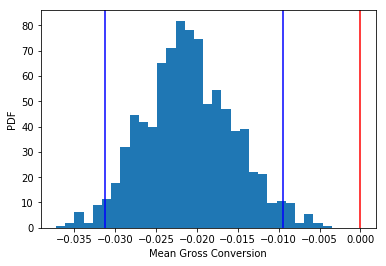

In [29]:
# Plot a histogram of bootstrap replicates

_ = plt.hist(bs_replicates, bins=30, normed = True)

_ = plt.xlabel('Mean Gross Conversion')

_ = plt.ylabel('PDF')

plt.axvline(x=bci_lower, c='b')
plt.axvline(x=bci_upper, c='b')
plt.axvline(x=0, c='r')

plt.show()


If we repeated measurements over and over again, 95% of the observed values would lie within the 95% confidence interval. 

#### 2. Sign Tests

In [30]:
# Sign test for Gross Conversion
stats.binom_test(4, n=23, p=0.5, alternative='two-sided')

0.0025994777679443364

In [31]:
# Sign test for Retention
stats.binom_test(13, n=23, p=0.5, alternative='two-sided')

0.6776394844055175

In [32]:
# Sign test for Net Conversion 
stats.binom_test(10, n=23, p=0.5, alternative='two-sided')

0.6776394844055175

The sign test for **Gross Conversion** appears to be statistically significant, that is, there was a significant change between the control and experiment groups in this experiment. 

The following chart gives us a closer look at the data for Retention and Net Conversion by date:

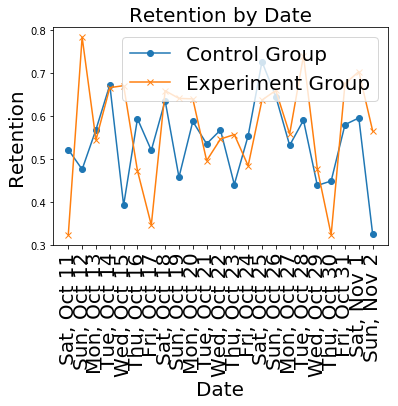

In [33]:
plt.plot(df[df["Group"] == 0]["Date"], 
         df[df["Group"] == 0]["Payments"]/df[df["Group"]==0]["Enrollments"],
         '-o', label = 'Control Group')


plt.plot(df[df["Group"] == 1]["Date"], 
         df[df["Group"] == 1]["Payments"]/df[df["Group"]==1]["Enrollments"],
         '-x', label = 'Experiment Group')

plt.legend(loc='upper right', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Retention', fontsize=20)
plt.xticks(rotation='vertical', fontsize = 20)
plt.title('Retention by Date', fontsize=20)

plt.rcParams["figure.figsize"] = (20,10)

plt.show()

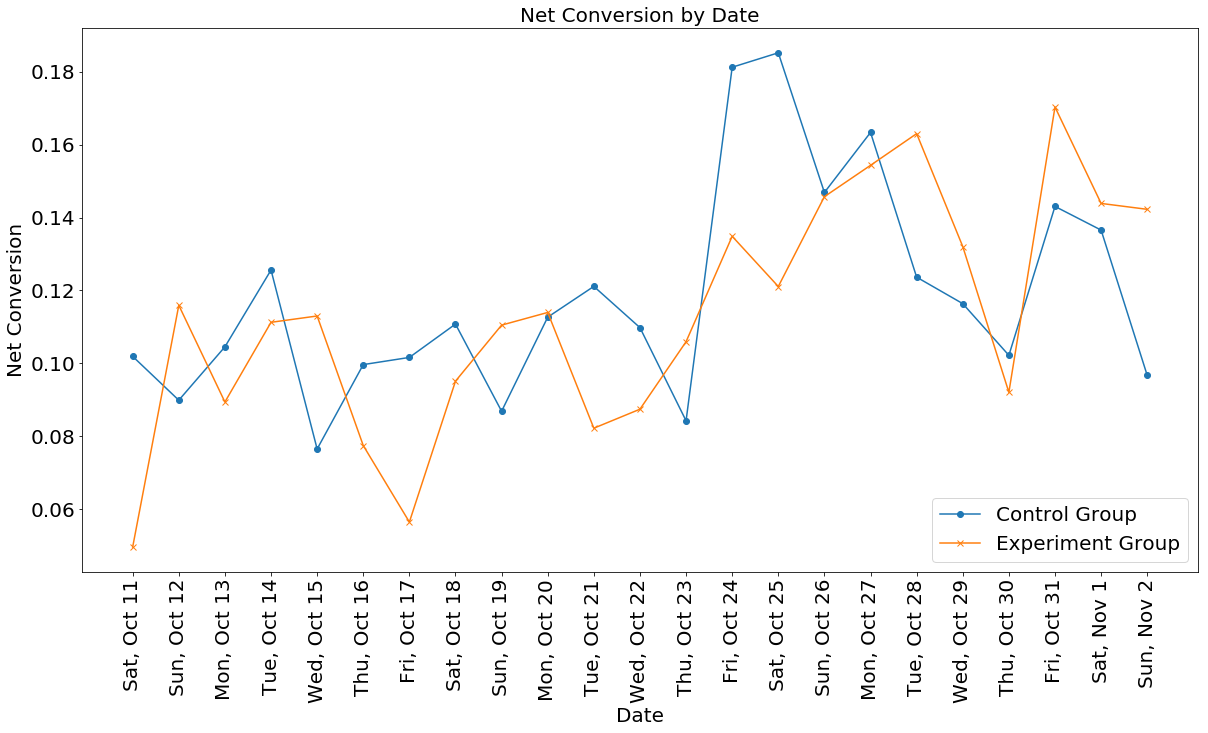

In [34]:
plt.plot(df[df["Group"] == 0]["Date"], 
         df[df["Group"] == 0]["Payments"]/df[df["Group"]==0]["Clicks"],
         '-o', label = 'Control Group')


plt.plot(df[df["Group"] == 1]["Date"], 
         df[df["Group"] == 1]["Payments"]/df[df["Group"]==1]["Clicks"],
         '-x', label = 'Experiment Group')

plt.legend(loc='lower right', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Net Conversion', fontsize=20)
plt.xticks(rotation='vertical', fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Net Conversion by Date', fontsize=20)

plt.rcParams["figure.figsize"] = (20,10)

plt.show()

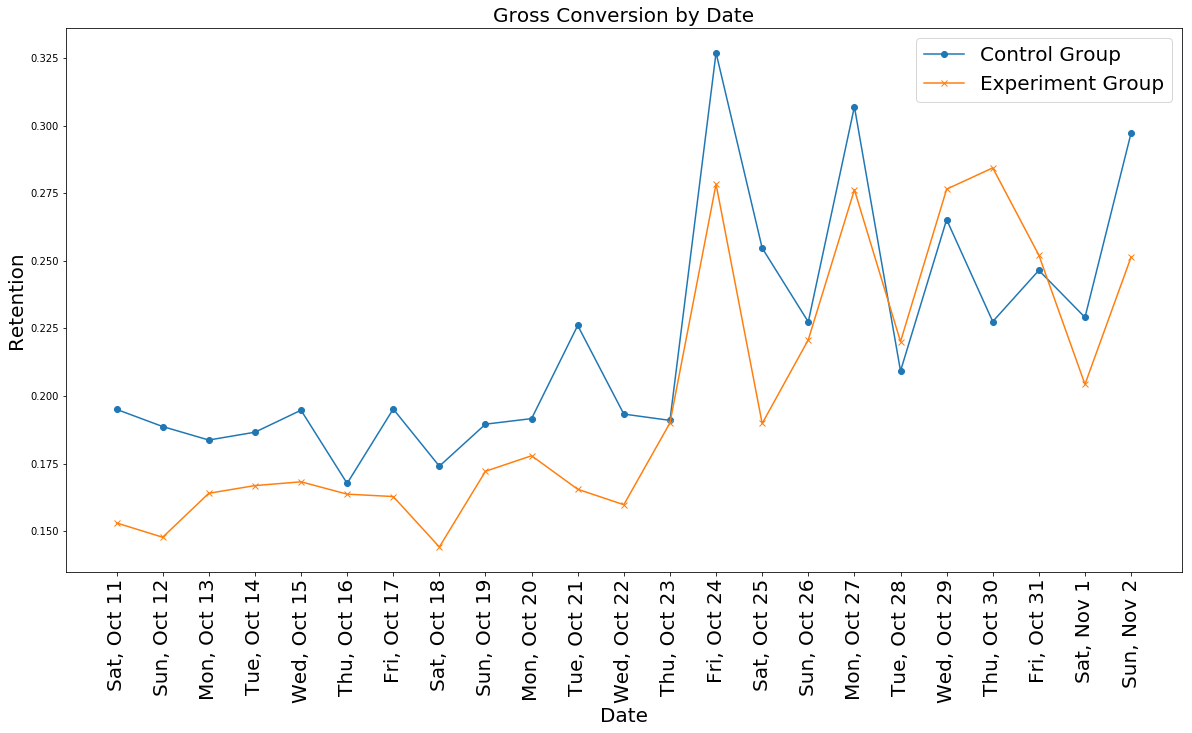

In [35]:

plt.plot(df[df["Group"] == 0]["Date"], 
         df[df["Group"] == 0]["Enrollments"]/df[df["Group"]==0]["Clicks"],
         '-o', label = 'Control Group')


plt.plot(df[df["Group"] == 1]["Date"], 
         df[df["Group"] == 1]["Enrollments"]/df[df["Group"]==1]["Clicks"],
         '-x', label = 'Experiment Group')

plt.legend(loc='upper right', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Retention', fontsize=20)
plt.xticks(rotation='vertical', fontsize = 20)
plt.title('Gross Conversion by Date', fontsize=20)

plt.rcParams["figure.figsize"] = (20,10)

plt.show()

#### 3. Summary 

### Recommendation

## Part IV: Follow-Up Experiment

### Reference

[Sign Test on wikipedia](https://en.wikipedia.org/wiki/Sign_test)